In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import seaborn as sns
from textwrap import fill
from synergy_dataset import Dataset, iter_datasets
from buscarpy import calculate_h0
from fastlite import *
from fastcore.utils import *
from fastcore.net import urlsave
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as pc

In [2]:
%%sh
bash sync.sh

In [3]:
dbpath = 'output_data/experiments.sql'
con = sqlite3.connect(dbpath)
rdf = pd.read_sql_query('SELECT * FROM reviews',con)
rdf

,review_id,review_name,n_records,prevalence
0,0,Appenzeller-Herzog_2019,2873,0.009050
1,1,Bos_2018,4878,0.002050
2,2,Brouwer_2019,38114,0.001627
3,3,Chou_2003,1908,0.007862
4,4,Chou_2004,1630,0.005521
5,5,Donners_2021,258,0.058140
6,6,Hall_2012,8793,0.011828
7,7,Jeyaraman_2020,1175,0.081702
8,8,Leenaars_2019,5812,0.002925
9,9,Leenaars_2020,7216,0.080793


In [4]:
d_map = {}
max_len = 10
for d in iter_datasets():
    ti = d.metadata['publication']['title']
    d_map[d.name] = fill(ti, width=80)
d_map

{'Appenzeller-Herzog_2019': 'Comparative effectiveness of common therapies for Wilson disease: A systematic\nreview and meta‐analysis of controlled studies',
 'Bos_2018': 'Cerebral small vessel disease and the risk of dementia: A systematic review and\nmeta‐analysis of population‐based evidence',
 'Brouwer_2019': 'Psychological theories of depressive relapse and recurrence: A systematic review\nand meta-analysis of prospective studies',
 'Chou_2003': 'Comparative efficacy and safety of long-acting oral opioids for chronic non-\ncancer pain: a systematic review',
 'Chou_2004': 'Comparative efficacy and safety of skeletal muscle relaxants for spasticity and\nmusculoskeletal conditions: a systematic review',
 'Donners_2021': 'Pharmacokinetics and Associated Efficacy of Emicizumab in Humans: A Systematic\nReview',
 'Hall_2012': 'A Systematic Literature Review on Fault Prediction Performance in Software\nEngineering',
 'Jeyaraman_2020': 'Does the Source of Mesenchymal Stem Cell Have an Effe

In [5]:
def proc_llm_df(llm_df):
    llm_df['pred'] = llm_df['py'] - llm_df['pn']    
    llm_df['pmass'] = llm_df['py'] + llm_df['pn']
    llm_df['alt_pred'] = llm_df['pred'] * llm_df['pmass']
    # Sort LLM results in descending order of pred, the order we would screen them
    llm_df = llm_df.sort_values('pred', ascending=False)
    # Calculate recall, the order, and x, the proportion of documents screened
    
    llm_df['recall'] = llm_df['y'].cumsum() / llm_df['y'].sum()
    llm_df['order'] = np.arange(llm_df.shape[0])
    llm_df['x'] = llm_df['order'] / llm_df.shape[0] 
    return llm_df

In [6]:
models = [
    "meta-llama/Meta-Llama-3.1-70B-Instruct",
    "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "meta-llama/Llama-2-7b-chat-hf",
    "meta-llama/Llama-2-70b-chat-hf",
    # "meta-llama/Llama-2-13b-chat",
    # "meta-llama/Llama-2-70b-chat"
]

In [7]:
rdf

,review_id,review_name,n_records,prevalence
0,0,Appenzeller-Herzog_2019,2873,0.009050
1,1,Bos_2018,4878,0.002050
2,2,Brouwer_2019,38114,0.001627
3,3,Chou_2003,1908,0.007862
4,4,Chou_2004,1630,0.005521
5,5,Donners_2021,258,0.058140
6,6,Hall_2012,8793,0.011828
7,7,Jeyaraman_2020,1175,0.081702
8,8,Leenaars_2019,5812,0.002925
9,9,Leenaars_2020,7216,0.080793


In [8]:
pq.read_table(
    f'output_data/llm_preds'
)['model'].unique().dictionary.to_pylist()

['meta-llama/Llama-2-70b-chat-hf',
 'meta-llama/Llama-2-7b-chat-hf',
 'meta-llama/Meta-Llama-3.1-70B-Instruct',
 'meta-llama/Meta-Llama-3.1-8B-Instruct']

In [9]:
rdf.shape[0]
import itertools
combinations = list(itertools.product(rdf.review_name, models))
len(combinations)

104

In [10]:
rank = 2
runs = [x for i,x in enumerate(combinations) if i%100==rank]
runs

[('Appenzeller-Herzog_2019', 'meta-llama/Llama-2-7b-chat-hf'),
 ('Wolters_2018', 'meta-llama/Llama-2-7b-chat-hf')]

In [11]:
for review_id, model in runs:
    print(review_id)
    print(model)

Appenzeller-Herzog_2019
meta-llama/Llama-2-7b-chat-hf
Wolters_2018
meta-llama/Llama-2-7b-chat-hf


In [12]:
model = models[1]
review_name = 'Appenzeller-Herzog_2019'
llm_df = pq.read_table(
    f'output_data/llm_preds',
    filters=[
        ('review', '=', review_name),
        ('model', '=', model)
    ]
).to_pandas().dropna()
llm_df

,y,py,pn,pred,screened_order,p_0.8,p_0.9,p_0.95,p_0.99,review,model
openalex_id,,,,,,,,,,,
https://openalex.org/W2607657572,0,0.975867,0.011476,0.964391,10,0.998955,0.998955,0.998955,0.998955,Appenzeller-Herzog_2019,meta-llama/Meta-Llama-3.1-8B-Instruct
https://openalex.org/W2093266833,0,0.976630,0.013116,0.963513,11,0.998955,0.998955,0.998955,0.998955,Appenzeller-Herzog_2019,meta-llama/Meta-Llama-3.1-8B-Instruct
https://openalex.org/W2023411819,0,0.976416,0.014902,0.961514,12,0.998955,0.998955,0.998955,0.998955,Appenzeller-Herzog_2019,meta-llama/Meta-Llama-3.1-8B-Instruct
https://openalex.org/W854776818,0,0.974803,0.013418,0.961385,13,0.998955,0.998955,0.998955,0.998955,Appenzeller-Herzog_2019,meta-llama/Meta-Llama-3.1-8B-Instruct
https://openalex.org/W2091516044,0,0.975182,0.013807,0.961375,14,0.998955,0.998955,0.998955,0.998955,Appenzeller-Herzog_2019,meta-llama/Meta-Llama-3.1-8B-Instruct
...,...,...,...,...,...,...,...,...,...,...,...
https://openalex.org/W2426015457,0,-0.985729,0.989770,-1.975499,5741,0.009972,0.009402,0.009816,0.011364,Appenzeller-Herzog_2019,meta-llama/Meta-Llama-3.1-8B-Instruct
https://openalex.org/W2543895988,0,-0.985663,0.992319,-1.977982,5742,0.009972,0.009402,0.009816,0.011364,Appenzeller-Herzog_2019,meta-llama/Meta-Llama-3.1-8B-Instruct
https://openalex.org/W4249121410,0,-0.987634,0.991103,-1.978737,5743,0.009972,0.009402,0.009816,0.011364,Appenzeller-Herzog_2019,meta-llama/Meta-Llama-3.1-8B-Instruct


In [14]:
rdf

,review_id,review_name,n_records,prevalence
0,0,Appenzeller-Herzog_2019,2873,0.009050
1,1,Bos_2018,4878,0.002050
2,2,Brouwer_2019,38114,0.001627
3,3,Chou_2003,1908,0.007862
4,4,Chou_2004,1630,0.005521
5,5,Donners_2021,258,0.058140
6,6,Hall_2012,8793,0.011828
7,7,Jeyaraman_2020,1175,0.081702
8,8,Leenaars_2019,5812,0.002925
9,9,Leenaars_2020,7216,0.080793


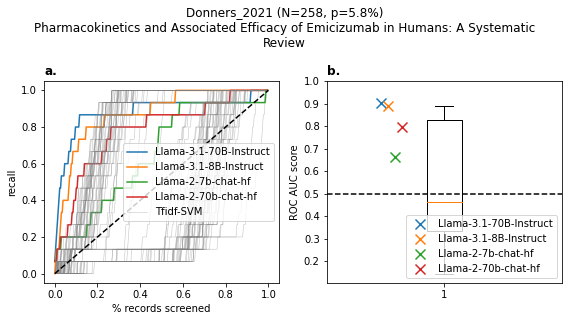

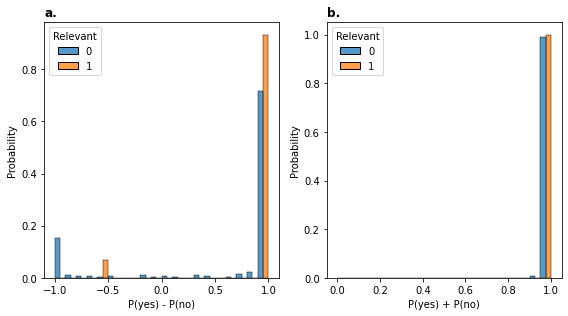

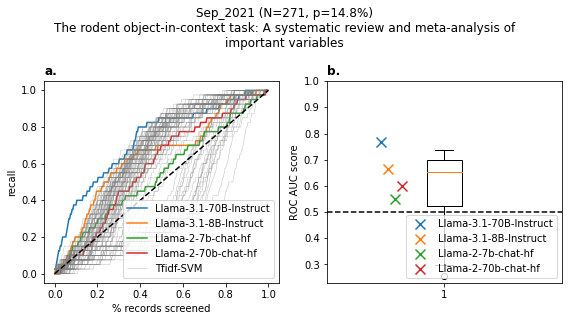

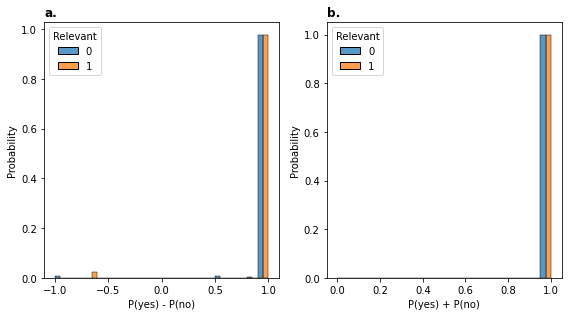

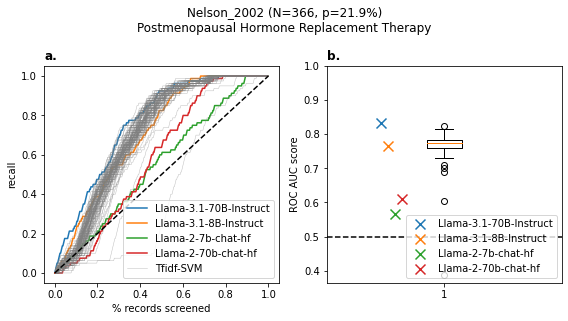

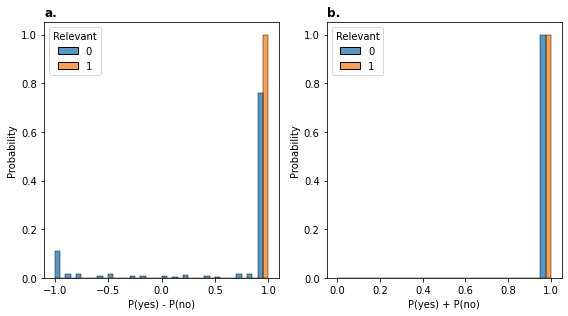

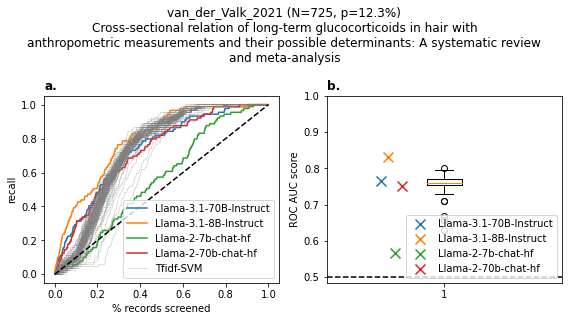

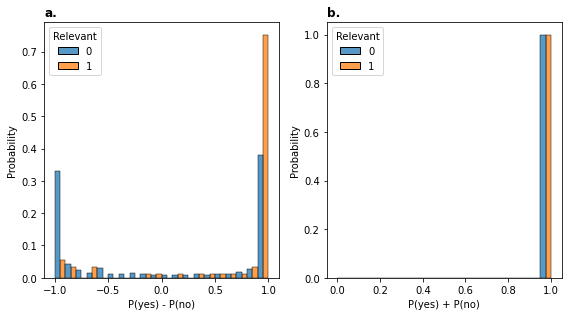

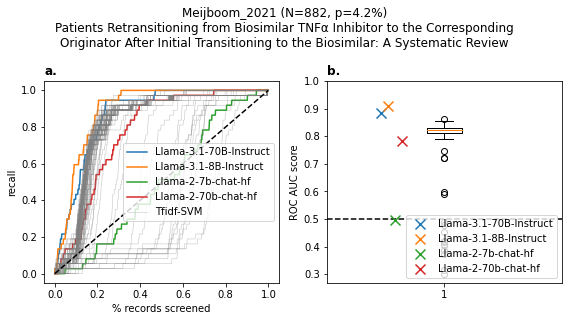

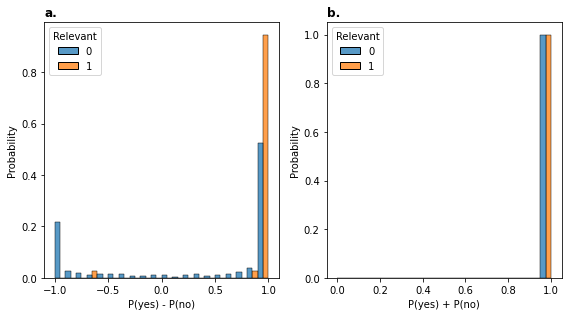

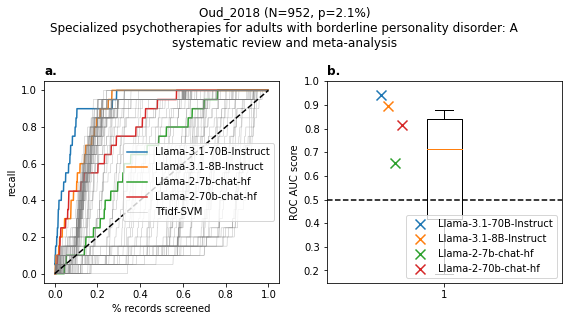

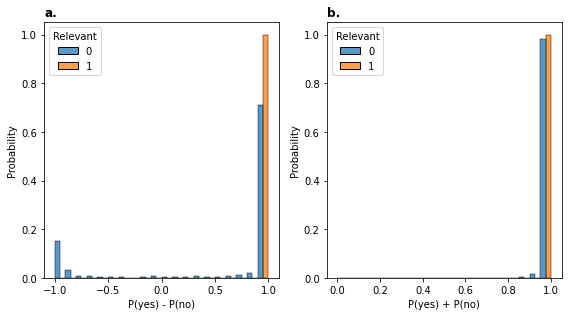

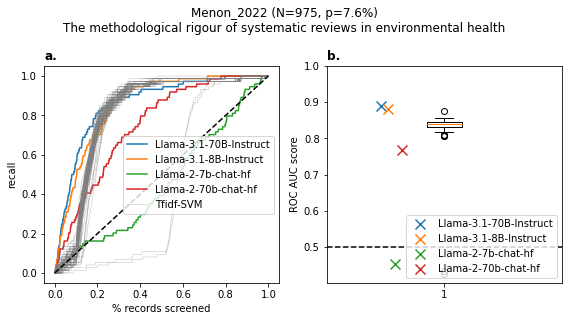

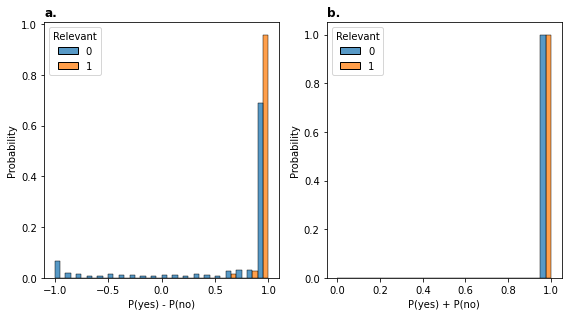

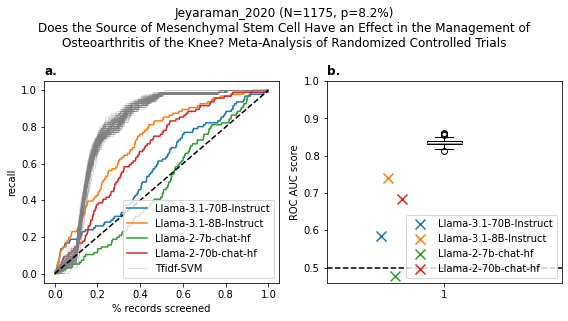

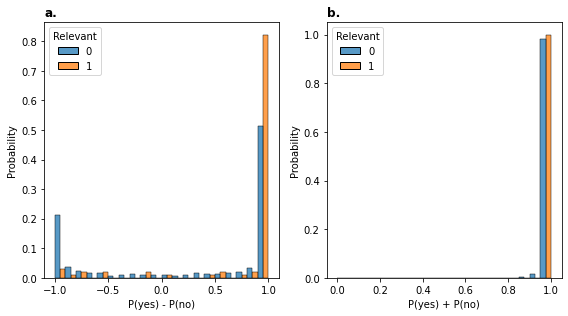

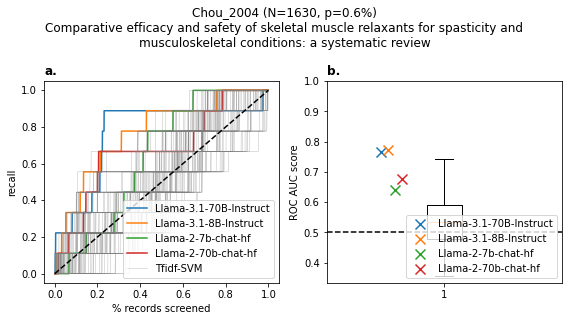

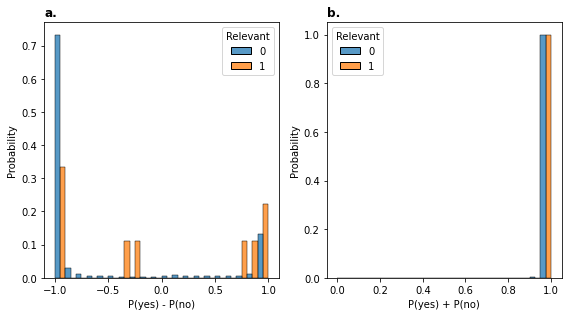

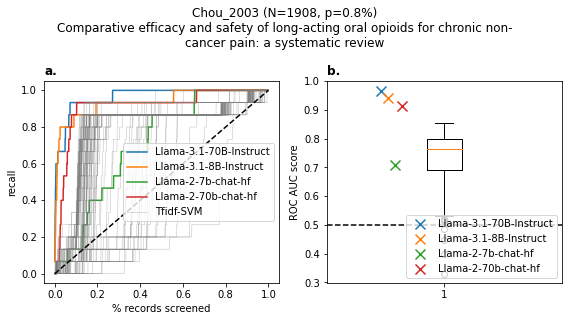

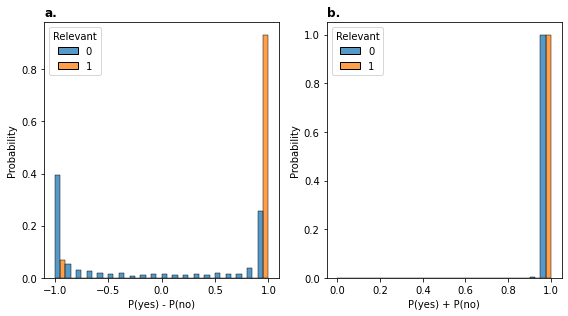

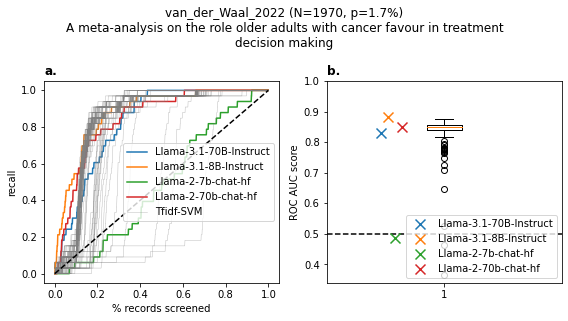

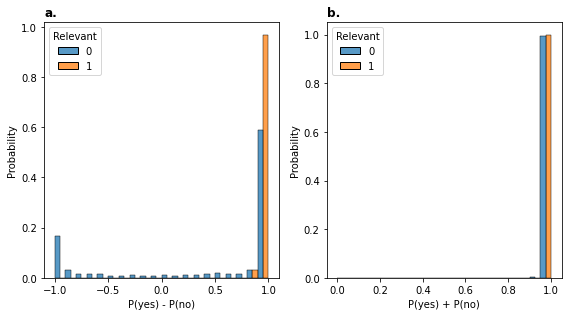

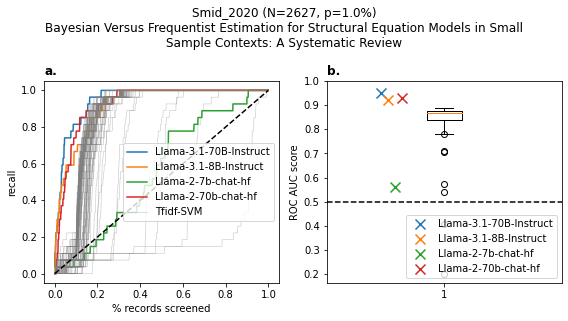

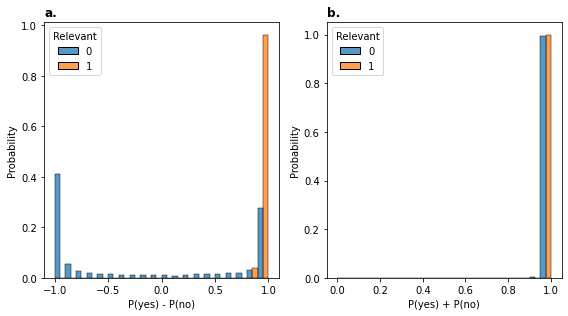

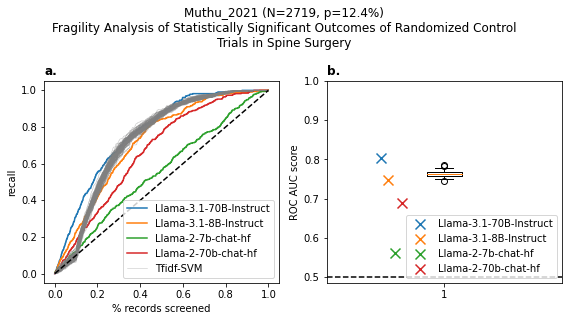

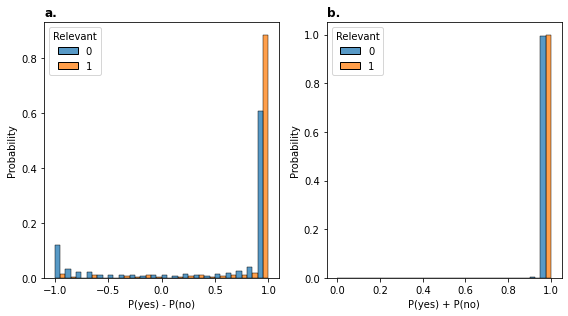

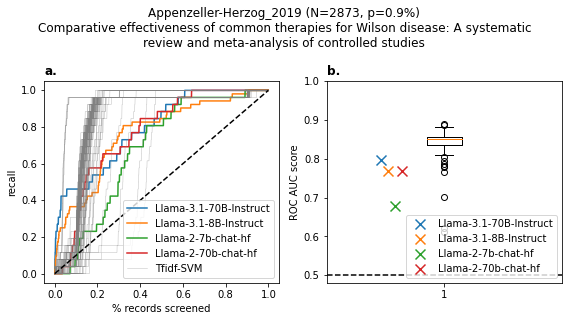

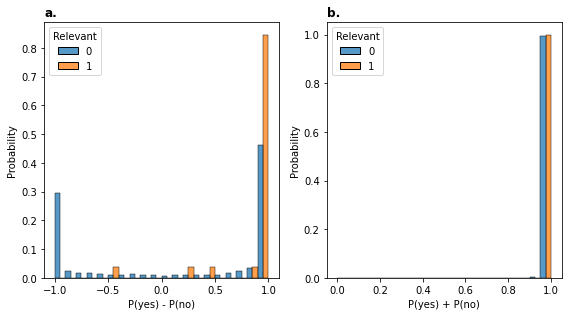

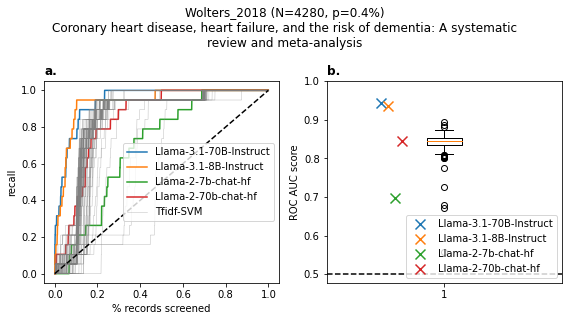

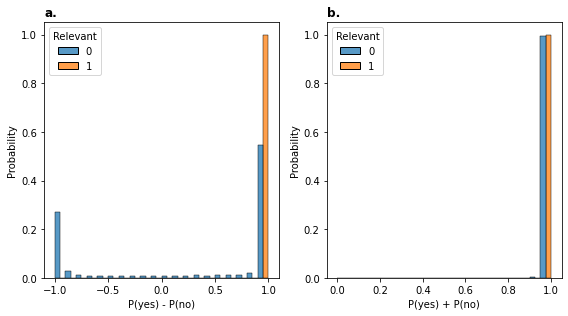

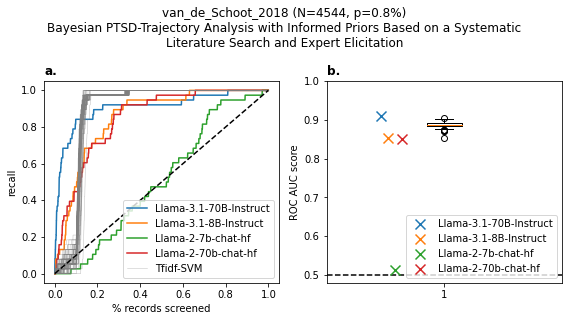

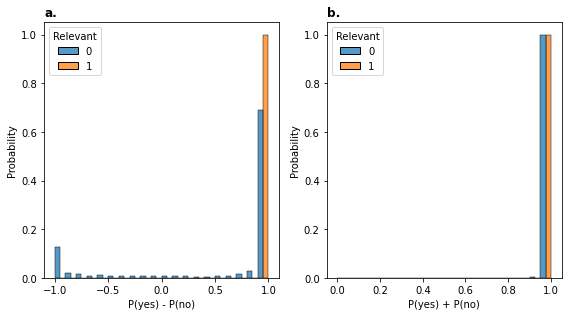

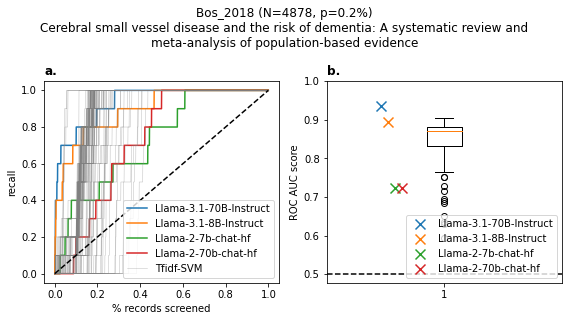

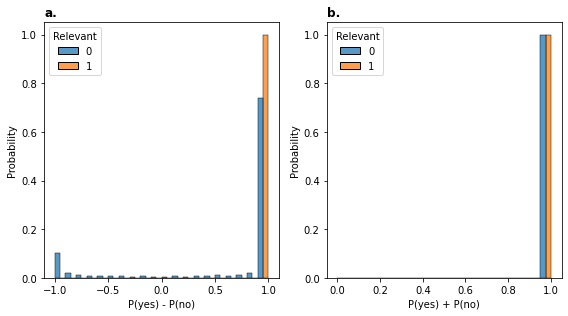

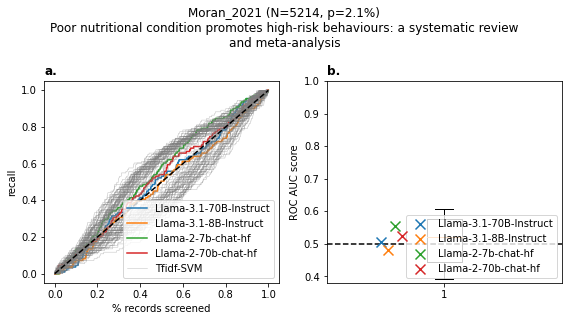

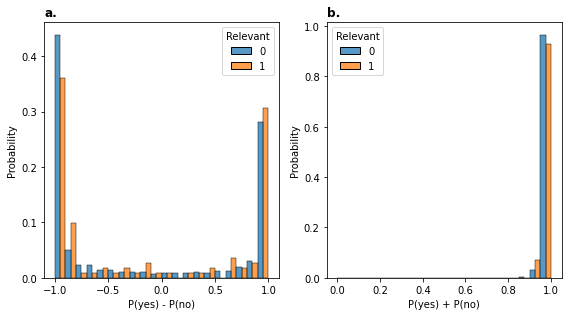

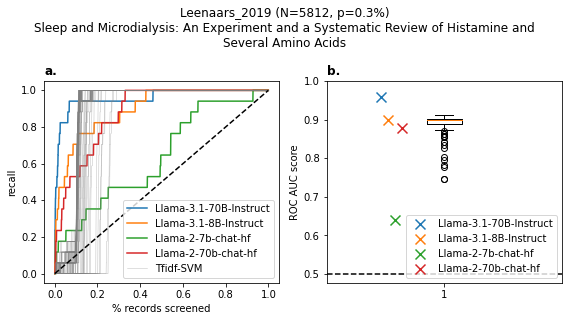

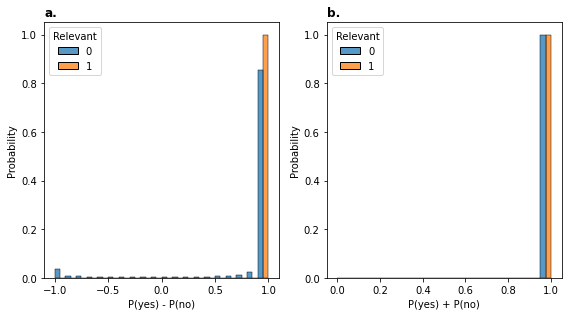

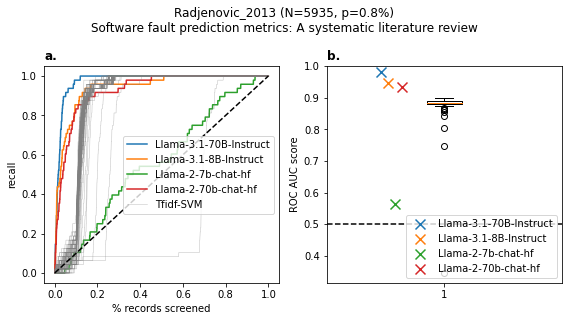

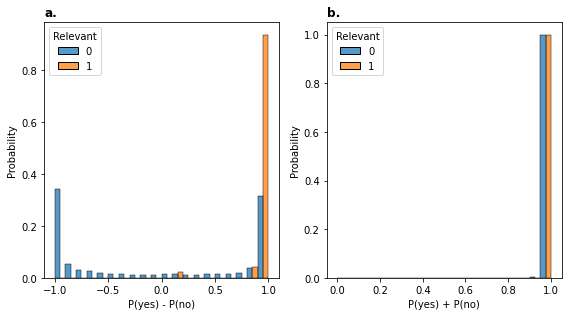

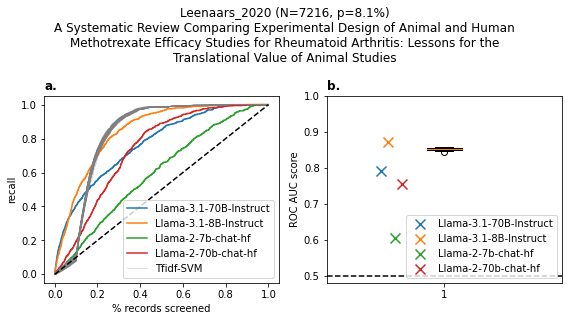

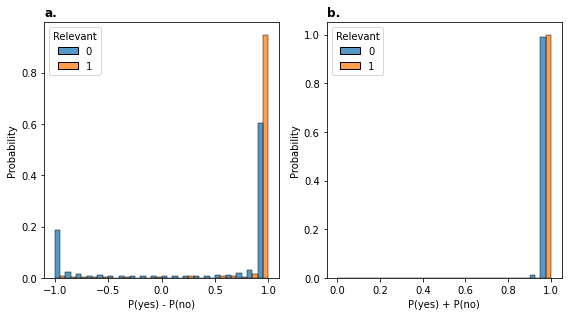

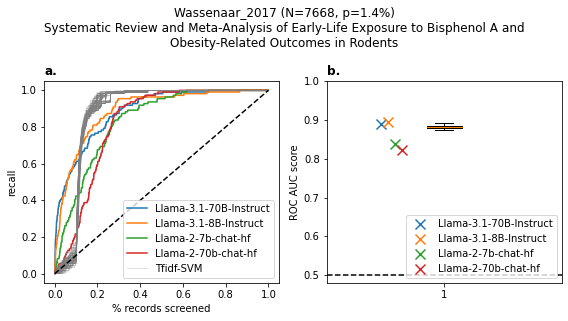

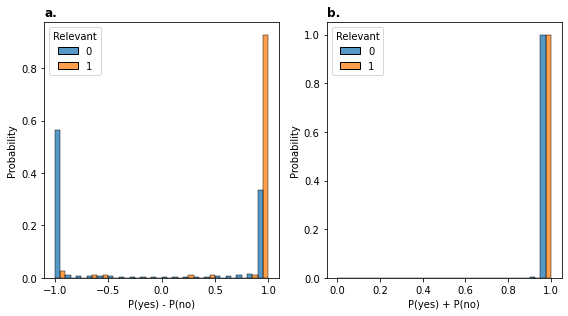

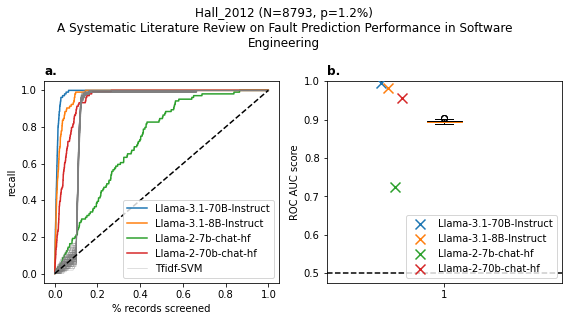

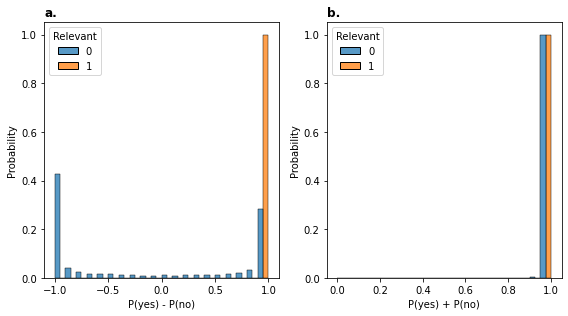

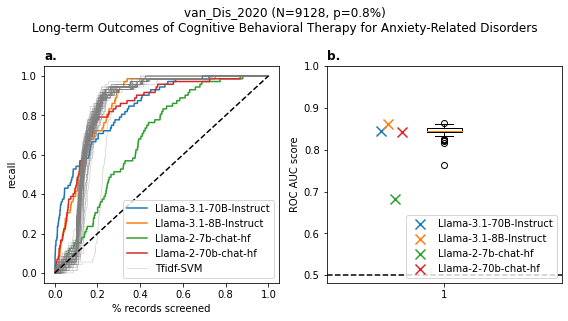

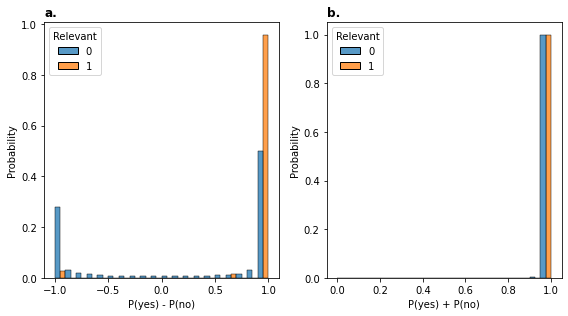

/tmp/ipykernel_234535/1218425582.py:131: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_234535/1218425582.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'figures/{review_name}.pdf', bbox_inches='tight')
/tmp/ipykernel_234535/1218425582.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'figures/{review_name}.pdf', bbox_inches='tight')
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


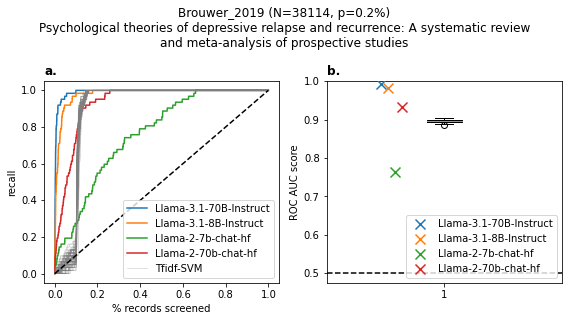

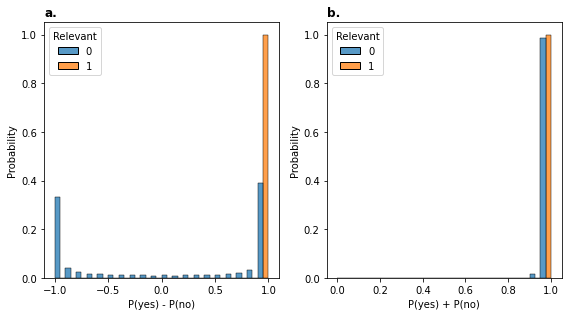

/tmp/ipykernel_234535/1218425582.py:131: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_234535/1218425582.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'figures/{review_name}.pdf', bbox_inches='tight')
/tmp/ipykernel_234535/1218425582.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'figures/{review_name}.pdf', bbox_inches='tight')
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


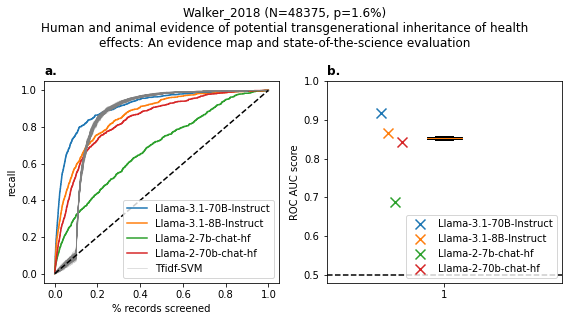

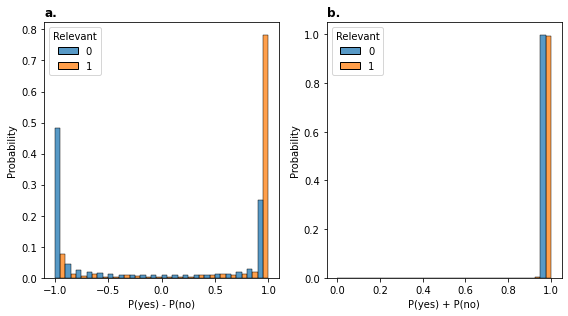

In [15]:
svm_auc_scores = []
llm_auc_scores = []
stopping_points = []

reviews = []


def order_score(x):
    return 1-(x-x.min())/(x.max()-x.min())

for r, row in rdf.sort_values('n_records').iterrows():
    review_name = row['review_name']
    table = pq.read_table(
        'output_data/ordered_records', 
        filters=[('review_id', '=', row['review_id'])]
    )
    
    # Setup graph with two panels
    fig, axs = plt.subplots(1,2, figsize=(8,4.5))
    axs[0].set_title('a.', loc='left', fontweight='bold')
    axs[1].set_title('b.', loc='left', fontweight='bold')
    ax = axs[0]
    
    llm_aucs = []
    for model in models:
        llm_res = pq.read_table(
            f'output_data/llm_preds',
            filters=[
                ('review', '=', review_name),
                ('model', '=', model)
            ]
        ).to_pandas()#.dropna()

        if llm_res.shape[0] == 0:
            llm_aucs.append(None)
            continue

        llm_df = proc_llm_df(llm_res)

        # Plot LLM recall curve
        ax.plot(llm_df['x'], llm_df['recall'], label=model.split('/')[1].replace('Meta-',''))
        # Calculate LLM ROC AUC score and plot it with an x
        auc = roc_auc_score(llm_df['y'], llm_df['pred'])
        llm_aucs.append(auc)
        
        # record stopping citeria
        for r in [0.8,0.9,0.95,0.99]:
            for c in [0.5,0.66,0.8,0.9,0.95,0.99]:
                s_point = llm_df.loc[llm_df[f'p_{r}']<1-c,]
                sres = {
                    'recall_target': r,
                    'confidence': c,
                    'model': model,
                    'run_id': 0,
                    'review_name': review_name
                }
                if s_point.shape[0]==0:
                    s_point = llm_df.tail(1)
                sres[f'recall'] = s_point['recall'].values[0]
                sres[f'wss'] = llm_df.shape[0] - s_point['order'].values[0]
                sres['wss_p'] = sres['wss'] / llm_df.shape[0]
                stopping_points.append(sres)
        
    llm_auc_scores.append(llm_aucs)
            
    if llm_df.shape[0]==0:
        continue
        
    

    study_title = f'{review_name} (N={llm_df.shape[0]}, p={llm_df["y"].sum()/llm_df.shape[0]:.1%})'
    reviews.append(study_title)
    plt.suptitle(study_title + '\n' + d_map[review_name])

    #  Go through each active learning run, and plot progress
    aucs = []

    for i, (name, group) in enumerate(table.to_pandas().groupby('run_id', observed=False)):
        group = group.sort_values('screened_order').reset_index()
        group['score'] = order_score(group['screened_order'])
        group['x'] = group['screened_order'] / group.shape[0]
        group['recall'] = group['relevant'].cumsum()/group['relevant'].sum()
        aucs.append(roc_auc_score(group['relevant'],group['score']))
        ax.plot(group['x'], group['recall'], color='grey',alpha=0.5,lw=0.5, label='Tfidf-SVM' if i==0 else None)
        
        # record stopping points
        for r in [0.8,0.9,0.95,0.99]:
            for c in [0.5,0.66,0.8,0.9,0.95,0.99]:
                sres = {
                    'recall_target': r,
                    'confidence': c,
                    'run_id': name,
                    'model': 'SVM',
                    'review_name': review_name
                }
                s_point = group.loc[group[f'p_{r}']<1-c,]
                if s_point.shape[0]==0:
                    s_point = group.tail(1)
                sres[f'recall'] = s_point['recall'].values[0]
                sres[f'wss'] = group.shape[0] - s_point['screened_order'].values[0]
                sres['wss_p'] = sres['wss'] / group.shape[0]
                stopping_points.append(sres)
    svm_auc_scores.append(aucs)

    # Plot a diagonal line showing random chance
    ax.plot([0,1],[0,1], color='black',ls='--')

    ax.legend()

    # Show the distribution of ROC AUC scores
    axs[1].boxplot(aucs)
    axs[1].axhline(0.5, color='black', ls='--')
    
    j = 0
    for m, s in zip(models, llm_aucs):
        j+=1
        axs[1].scatter(
            0.7+j*0.03, s,     
            marker='x',
            s=100,
            zorder=50,
            label=m.split('/')[1].replace('Meta-','')
        )

    # Legend and axis labels
    axs[1].legend(loc='lower right')
    axs[0].set_xlabel('% records screened')
    axs[0].set_ylabel('recall')
    axs[1].set_ylim(ymax=1)
    axs[1].set_ylabel('ROC AUC score')
    plt.tight_layout()
    plt.savefig(f'figures/{review_name}.pdf', bbox_inches='tight')
    plt.show()

    # New plot for distribution of p scores
    fig, axs = plt.subplots(1,2, figsize=(8,4.5))

    # Distribution of p(Yes)-P(no)
    g = sns.histplot(
        llm_df, hue='y', x='pred', stat='probability', 
        multiple='dodge', common_norm=False, ax=axs[0],
        binwidth=0.1, binrange=[-1,1], legend=True,
    )
    leg = g.axes.get_legend()
    leg.set_title('Relevant')
    axs[0].set_xlabel('P(yes) - P(no)')

    # Distribution of p(Yes)+P(no)
    g = sns.histplot(
        llm_df, hue='y', x='pmass', stat='probability', 
        multiple='dodge', common_norm=False, ax=axs[1],
        binwidth=0.05, binrange=[0,1], legend=True,
    )
    leg = g.axes.get_legend()
    leg.set_title('Relevant')
    axs[1].set_xlabel('P(yes) + P(no)')
    #plt.suptitle(study_title + '\n' + d_map[review])
    
    axs[0].set_title('a.', loc='left', fontweight='bold')
    axs[1].set_title('b.', loc='left', fontweight='bold')

    fig.tight_layout()
    plt.savefig(f'figures/{review_name}_p_distribution.pdf', bbox_inches='tight')
    plt.show()

In [16]:
# table = pq.read_table(
#     'output_data/ordered_records', 
#     filters=[
#         ('review_id', '=', 1),
#         ('run_id','=',1)
#     ]
# ).to_pandas().sort_values('screened_order').reset_index(drop=True)
# batch_size = 1000
# for recall_target in [0.8,0.9,0.95,0.99]:
#     pdf = pd.DataFrame(
#         retrospective_h0(
#             table['relevant'], table.shape[0], 
#             batch_size=batch_size, plot=False, recall_target=recall_target,
#             confidence_level=0.99
#         )
#     ).rename(columns={'p': f'p_{recall_target}'})
#     table = table.merge(
#         pdf, left_on='screened_order', right_on='batch_sizes', how='left'
#     ).drop(columns='batch_sizes').ffill()
# table

In [17]:
sdf = pd.DataFrame.from_dict(stopping_points).merge(rdf[['review_name','n_records','prevalence']])
sdf

,recall_target,confidence,model,run_id,review_name,recall,wss,wss_p,n_records,prevalence
0,0.80,0.50,meta-llama/Meta-Llama-3.1-70B-Instruct,0,Donners_2021,0.866667,188.0,0.728682,258,0.058140
1,0.80,0.66,meta-llama/Meta-Llama-3.1-70B-Instruct,0,Donners_2021,0.866667,168.0,0.651163,258,0.058140
2,0.80,0.80,meta-llama/Meta-Llama-3.1-70B-Instruct,0,Donners_2021,0.933333,108.0,0.418605,258,0.058140
3,0.80,0.90,meta-llama/Meta-Llama-3.1-70B-Instruct,0,Donners_2021,0.933333,88.0,0.341085,258,0.058140
4,0.80,0.95,meta-llama/Meta-Llama-3.1-70B-Instruct,0,Donners_2021,0.933333,78.0,0.302326,258,0.058140
...,...,...,...,...,...,...,...,...,...,...
64891,0.99,0.66,SVM,99,Walker_2018,0.993438,13095.0,0.270698,48375,0.015752
64892,0.99,0.80,SVM,99,Walker_2018,0.993438,12255.0,0.253333,48375,0.015752
64893,0.99,0.90,SVM,99,Walker_2018,0.993438,11235.0,0.232248,48375,0.015752
64894,0.99,0.95,SVM,99,Walker_2018,0.993438,10305.0,0.213023,48375,0.015752


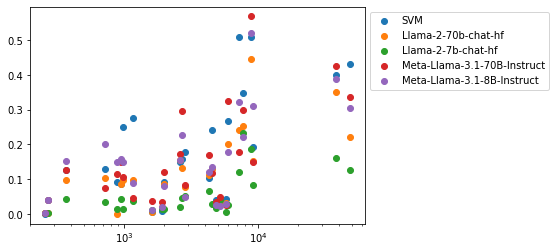

In [18]:
fig, ax = plt.subplots()

sdf_rc = sdf[(sdf['recall_target']==0.95) & (sdf['confidence']==0.95)]

for name, group in sdf_rc.groupby('model'):
    group = group[['n_records','wss_p','review_name']].groupby('review_name').median()
    ax.scatter(group['n_records'], group['wss_p'], label=name.split('/')[-1])
ax.set_xscale('log')
ax.legend(bbox_to_anchor=(1,1))

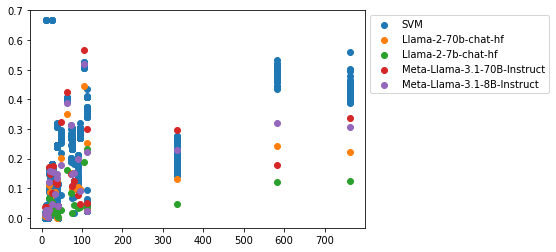

In [19]:
fig, ax = plt.subplots()
for name, group in sdf_rc.groupby('model'):
    ax.scatter(group['n_records']*group['prevalence'], group['wss_p'], label=name.split('/')[-1])
    
ax.legend(bbox_to_anchor=(1,1))
#ax.set_xscale('log')

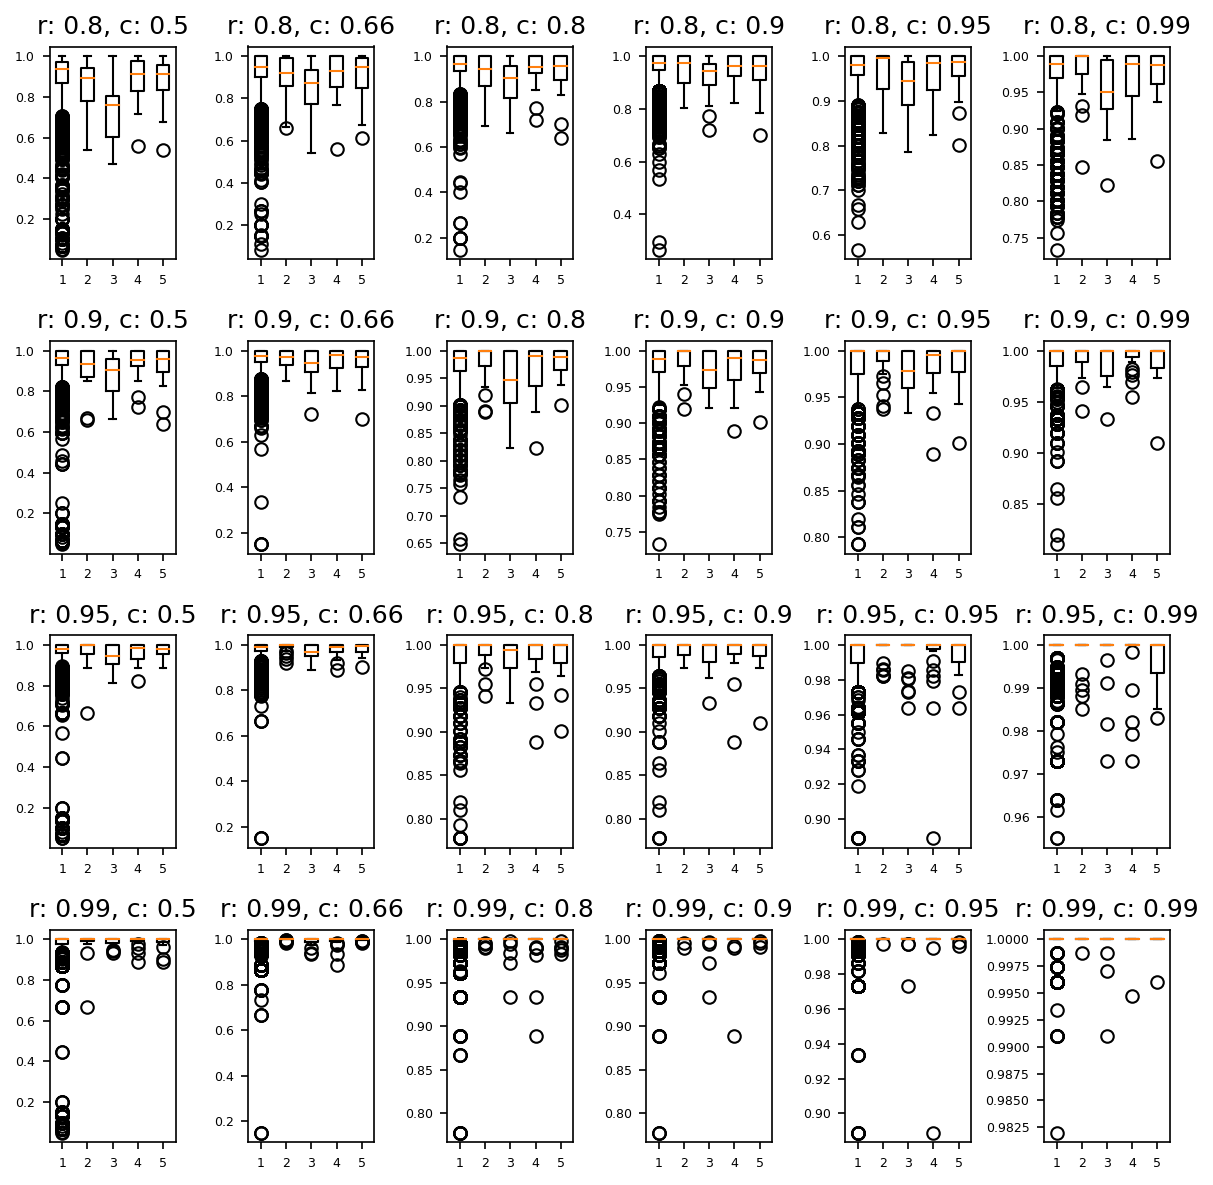

In [20]:
recall_levels = [0.8,0.9,0.95,0.99]
conf_levels = [0.5,0.66,0.8,0.9,0.95,0.99]



fig, axs = plt.subplots(len(recall_levels), len(conf_levels), figsize=(8,8), dpi=150)

for i, r in enumerate(recall_levels):
    for j, c in enumerate(conf_levels):
        ax = axs[i,j]
        ax.set_title(f'r: {r}, c: {c}')
        group = sdf[
            (sdf['recall_target']==r) &
            (sdf['confidence']==c)
        ]
        data, names = zip(*[(g['recall'], name) for name, g in group.groupby('model')])
        ax.boxplot(data)
        ax.tick_params(labelsize=6)
        
fig.tight_layout()

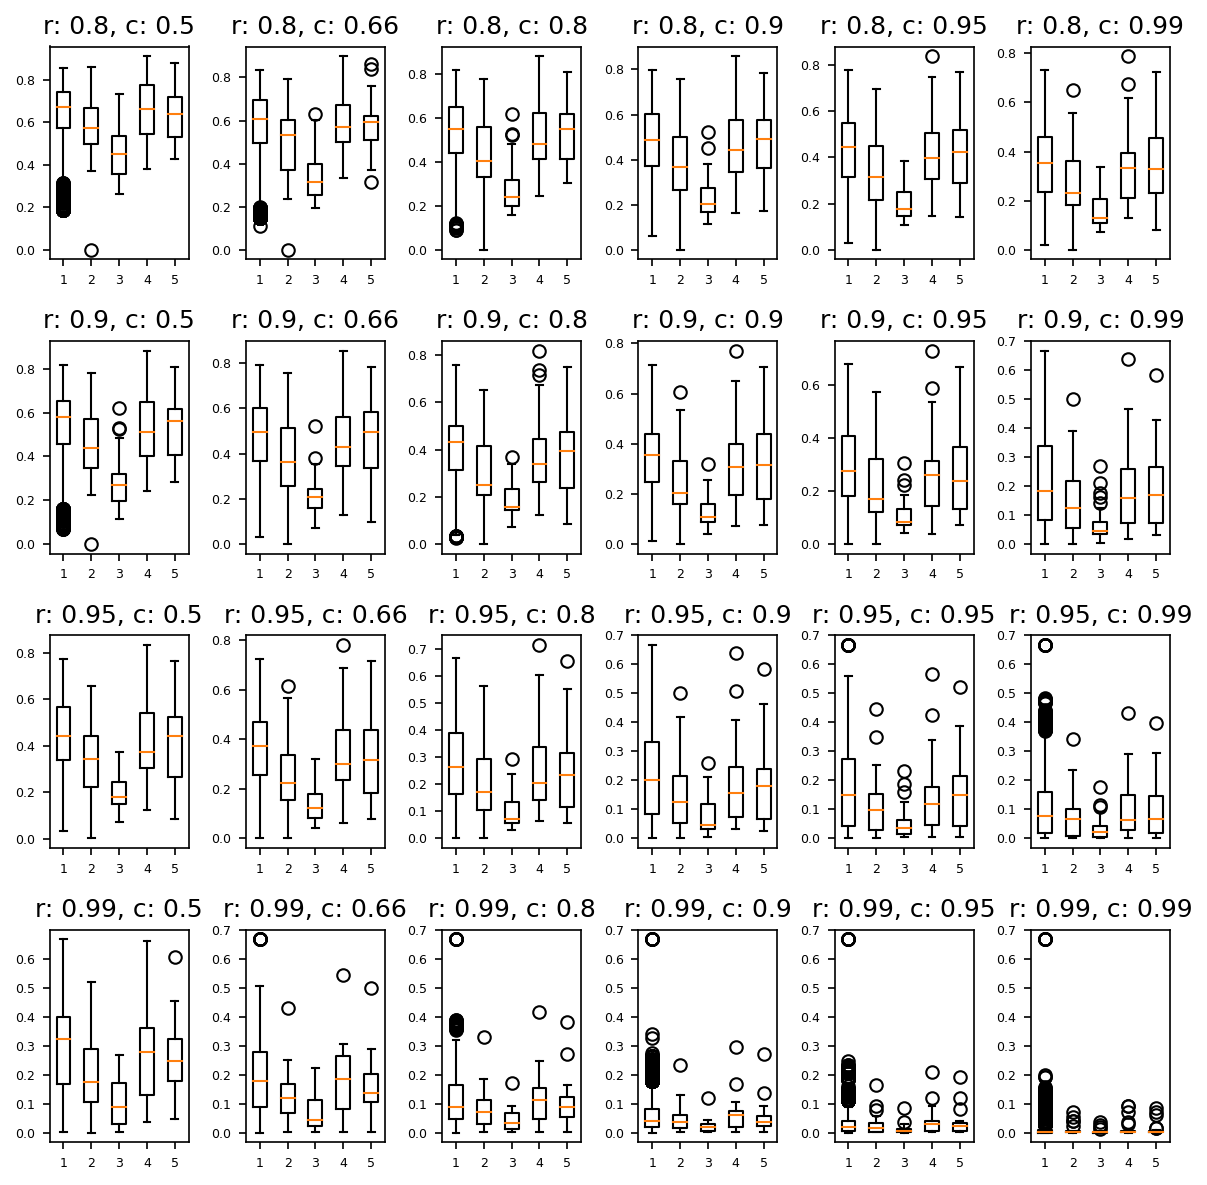

In [21]:
recall_levels = [0.8,0.9,0.95,0.99]
conf_levels = [0.5,0.66,0.8,0.9,0.95,0.99]

fig, axs = plt.subplots(len(recall_levels), len(conf_levels), figsize=(8,8), dpi=150)

for i, r in enumerate(recall_levels):
    for j, c in enumerate(conf_levels):
        ax = axs[i,j]
        ax.set_title(f'r: {r}, c: {c}')
        group = sdf[
            (sdf['recall_target']==r) &
            (sdf['confidence']==c)
        ]
        data, names = zip(*[(g['wss_p'], name) for name, g in group.groupby('model')])
        ax.boxplot(data)
        ax.tick_params(labelsize=6)
        
fig.tight_layout()

In [22]:
def clean_model_title(x):
    x = x.split('/')[-1]
    x = x.replace('Meta-','')
    x = x.replace('-Instruct','')
    x = x.replace('-chat-hf','')
    return x
models_short = [clean_model_title(x) for x in models]
models_short

['Llama-3.1-70B', 'Llama-3.1-8B', 'Llama-2-7b', 'Llama-2-70b']

In [23]:
col_order = [
    'SVM',
    'Llama-2-7b',
    'Llama-2-70b',
    'Llama-3.1-8B',
    'Llama-3.1-70B',
]

In [24]:
rdf['n_records'].sum()

169288

In [25]:
rdf['n_records'].min()


258

In [26]:
rdf['n_records'].max()

48375

In [27]:
7980/rdf['n_records'].sum()

0.0471386040357261

In [28]:

def sum_f(x):
    return sum


sdf['model'] = sdf['model'].apply(lambda x: clean_model_title(x))
tab = sdf[sdf['confidence'].isin([0.5,0.8,0.9,0.95,0.99])].groupby(
    ['model','review_name','recall_target','confidence']
)['wss'].median().reset_index().rename(columns={'recall_target':'r target','confidence': 'confidence'}).pivot_table(
    index=['r target','confidence'],
    columns=['model'],
    values='wss',
    aggfunc=sum
).astype(int)#.reset_index()
tab
#tab.columns.name = None
# cols = [
#     'recall_target',
#     'confidence',
#     '
# tab = tab[['recall_
models_short = [clean_model_title(x) for x in models]

vis = tab[col_order].style.highlight_max(
    subset=['SVM'] + models_short,
    props='font-weight:bold;',
    #props='color:red',
    axis=1
).format(
    '{:,.0f}', subset = ['SVM'] + models_short
).format_index('{:.2f}')
out = tab[col_order].style.highlight_max(
    subset=['SVM'] + models_short,
    props='textbf:--rwrap',
    axis=1,
).format_index('{:.2f}').format('{:,d}')
out.to_latex(
    "tables/wsst.tex",
    hrules=True,
    multirow_align='naive',
    clines='skip-last;data'
)
vis

/tmp/ipykernel_234535/595555419.py:6: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  tab = sdf[sdf['confidence'].isin([0.5,0.8,0.9,0.95,0.99])].groupby(


In [29]:
tab.astype(int)

model                Llama-2-70b  Llama-2-7b  Llama-3.1-70B  Llama-3.1-8B  \
r target confidence                                                         
0.80     0.50             121777      100248         132808        127401   
         0.80              97147       64568         114748        111411   
         0.90              90327       57678         106668        101871   
         0.95              83338       48608         101288         94921   
         0.99              71397       37838          85058         79471   
0.90     0.50              99217       65778         115498        112011   
         0.80              79807       42768          97438         83661   
         0.90              65007       34158          82268         76701   
         0.95              59447       28748          73108         69251   
         0.99              49790       23118          59088         55091   
0.95     0.50              82907       44408         101318         94731   
         0.80              58587       27238          68678         64281   
         0.90              44470       21738          57388         53091   
         0.95              37370       18781          48671         45954   
         0.99              27171       13545          35592         34855   
0.99     0.50              42897       22638          55378         54811   
         0.80              20597       11158          30398         29191   
         0.90              13480        5825          18478         13641   
         0.95               8837        4065          11938          9435   
         0.99               4355        1985           6625          4934   

model                   SVM  
r target confidence          
0.80     0.50        126898  
         0.80        113708  
         0.90        105053  
         0.95         98503  
         0.99         87803  
0.90     0.50        114988  
         0.80         93923  
         0.90         84658  
         0.95         76483  
         0.99         62350  
0.95     0.50         98258  
         0.80         74098  
         0.90         63245  
         0.95         54860  
         0.99         41676  
0.99     0.50         63573  
         0.80         31323  
         0.90         21160  
         0.95         16229  
         0.99          7980

In [30]:
tab = sdf[sdf['confidence'].isin([0.5,0.8,0.9,0.95,0.99])]
s_dist = []

for (r,c,model), group in tab.groupby(['recall_target','confidence','model']):
    m = group['recall'].median()
    p = group['recall'].quantile(1-c)
    s_dist.append({
        'model': model,
        'recall_target': r,
        'confidence': c,
        'recall_m': m,
        'recall_p': p,
        'r': f'{m:.2f} ({p:.2f})'
    })
    
tab = pd.DataFrame.from_dict(s_dist).rename(columns={'recall_target':'r target','confidence': 'confidence'}).pivot(
    index=['r target','confidence'],
    columns=['model'],
    values='recall_p',
)

def toolow(val, style):
    """
    highlight in red if value is below recall target
    """
    test = val<val.name[0]
    return [style if v else '' for v in test]

vis = tab[col_order].style.apply(
    lambda x: toolow(x,'background-color: red'), axis=1,
).format(
    '{:,.3f}', subset = ['SVM'] + models_short
).format_index('{:.2f}')
out = tab[col_order].style.apply(
    lambda x: toolow(x,'textbf:--rwrap'), axis=1,
).format_index('{:.2f}').format('{:,.3f}')
out.to_latex(
    "tables/recall.tex",
    hrules=True,
    multirow_align='naive',
    clines='skip-last;data'
)
vis

In [31]:
def mean_dist(x):
    return f'{np.mean(x):.3f} ({np.std(x):.2f})'

sdf['model'] = sdf['model'].apply(lambda x: clean_model_title(x))
tab = sdf[sdf['confidence'].isin([0.5,0.8,0.9,0.95,0.99])].groupby(
    ['model','review_name','recall_target','confidence']
)['wss_p'].median().reset_index().rename(columns={'recall_target':'r target','confidence': 'confidence'}).pivot_table(
    index=['r target','confidence'],
    columns=['model'],
    values='wss_p',
    aggfunc=mean_dist
)#.reset_index()
#tab.columns.name = None


vis = tab[col_order].style.highlight_max(
    subset=['SVM'] + models_short,
    props='font-weight:bold;',
    axis=1
).format_index('{:.2f}')#.format(
#    '{:.2f}', subset=['recall_target','confidence']
#)
out = tab[col_order].style.highlight_max(
    subset=['SVM'] + models_short,
    props='textbf:--rwrap',
    axis=1,
).format_index('{:.2f}')
out.to_latex(
    "tables/wss_p.tex",
    hrules=True,
    multirow_align='naive',
    clines='skip-last;data'
)
vis

In [32]:
sdf.groupby(
    ['model','review_name','recall_target','confidence']
)['wss'].median().groupby(['model','recall_target','confidence']).count()

model        recall_target  confidence
Llama-2-70b  0.80           0.50          26
                            0.66          26
                            0.80          26
                            0.90          26
                            0.95          26
                                          ..
SVM          0.99           0.66          26
                            0.80          26
                            0.90          26
                            0.95          26
                            0.99          26
Name: wss, Length: 120, dtype: int64

In [33]:
sdf[
    (sdf['recall_target']==0.80) &
    (sdf['confidence']==0.5)
].groupby(
    ['model','review_name','recall_target','confidence']
)['wss_p'].median().reset_index().pivot(
    index=['review_name','recall_target','confidence'],
    columns=['model']
)

wss_p             \
model                                            Llama-2-70b Llama-2-7b   
review_name             recall_target confidence                          
Appenzeller-Herzog_2019 0.8           0.5           0.533589   0.505743   
Bos_2018                0.8           0.5           0.395244   0.440344   
Brouwer_2019            0.8           0.5           0.772262   0.607756   
Chou_2003               0.8           0.5           0.753669   0.454927   
Chou_2004               0.8           0.5           0.558282   0.276074   
Donners_2021            0.8           0.5           0.612403   0.341085   
Hall_2012               0.8           0.5           0.861253   0.549642   
Jeyaraman_2020          0.8           0.5           0.514894   0.336170   
Leenaars_2019           0.8           0.5           0.583620   0.593944   
Leenaars_2020           0.8           0.5           0.569013   0.537140   
Meijboom_2021           0.8           0.5           0.001134   0.444444   
Menon_2022              0.8           0.5           0.538462   0.261538   
Moran_2021              0.8           0.5           0.489835   0.453395   
Muthu_2021              0.8           0.5           0.536594   0.529239   
Nelson_2002             0.8           0.5           0.426230   0.316940   
Oud_2018                0.8           0.5           0.443277   0.411765   
Radjenovic_2013         0.8           0.5           0.765796   0.546757   
Sep_2021                0.8           0.5           0.372694   0.335793   
Smid_2020               0.8           0.5           0.638371   0.413780   
Walker_2018             0.8           0.5           0.832145   0.731266   
Wassenaar_2017          0.8           0.5           0.679186   0.640063   
Wolters_2018            0.8           0.5           0.579439   0.441589   
van_Dis_2020            0.8           0.5           0.757888   0.533304   
van_de_Schoot_2018      0.8           0.5           0.634683   0.478433   
van_der_Valk_2021       0.8           0.5           0.420690   0.448276   
van_der_Waal_2022       0.8           0.5           0.614213   0.304569   

                                                                             \
model                                            Llama-3.1-70B Llama-3.1-8B   
review_name             recall_target confidence                              
Appenzeller-Herzog_2019 0.8           0.5             0.432649     0.597981   
Bos_2018                0.8           0.5             0.569496     0.559246   
Brouwer_2019            0.8           0.5             0.904759     0.861993   
Chou_2003               0.8           0.5             0.779874     0.675052   
Chou_2004               0.8           0.5             0.607362     0.447853   
Donners_2021            0.8           0.5             0.728682     0.612403   
Hall_2012               0.8           0.5             0.911293     0.878312   
Jeyaraman_2020          0.8           0.5             0.378723     0.514894   
Leenaars_2019           0.8           0.5             0.810736     0.497591   
Leenaars_2020           0.8           0.5             0.650776     0.725610   
Meijboom_2021           0.8           0.5             0.693878     0.727891   
Menon_2022              0.8           0.5             0.671795     0.692308   
Moran_2021              0.8           0.5             0.453395     0.457231   
Muthu_2021              0.8           0.5             0.554983     0.499816   
Nelson_2002             0.8           0.5             0.480874     0.426230   
Oud_2018                0.8           0.5             0.768908     0.642857   
Radjenovic_2013         0.8           0.5             0.834878     0.784330   
Sep_2021                0.8           0.5             0.520295     0.520295   
Smid_2020               0.8           0.5             0.706890     0.626951   
Walker_2018             0.8           0.5             0.878450     0.795762   
Wassenaar_2017          0.8           0.5             0.655712

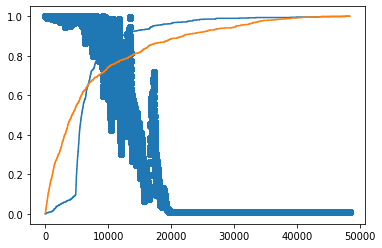

In [34]:
fig, ax = plt.subplots()
for i, (name, group) in enumerate(table.to_pandas().groupby('run_id', observed=False)):
    break
ax.plot(group['screened_order'], group['relevant'].cumsum()/group['relevant'].sum(),color='C0')
ax.plot(llm_df['order'], llm_df['recall'], color='C1')
ax.scatter(group['screened_order'], group['p_0.8'])

In [35]:
group

,rec_id,screened_order,relevant,first_prediction,last_prediction,p_0.8,p_0.9,p_0.95,p_0.99,review_id,run_id
0,https://openalex.org/W2057961597,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,23,1
1,https://openalex.org/W2020529657,2.0,0,NaN,NaN,NaN,NaN,NaN,NaN,23,1
2,https://openalex.org/W2091944526,3.0,0,NaN,NaN,NaN,NaN,NaN,NaN,23,1
3,https://openalex.org/W2467357490,4.0,0,NaN,NaN,NaN,NaN,NaN,NaN,23,1
4,https://openalex.org/W2023743080,5.0,0,NaN,NaN,NaN,NaN,NaN,NaN,23,1
...,...,...,...,...,...,...,...,...,...,...,...
48370,https://openalex.org/W2009155394,48371.0,0,0.002746,0.000250,0.009754,0.009886,0.009843,0.009995,23,1
48371,https://openalex.org/W2051246543,48372.0,0,0.003218,0.000246,0.009754,0.009886,0.009843,0.009995,23,1
48372,https://openalex.org/W2102882852,48373.0,0,0.005697,0.000245,0.009754,0.009886,0.009843,0.009995,23,1
48373,https://openalex.org/W2161495038,48374.0,0,0.002760,0.000217,0.009754,0.009886,0.009843,0.009995,23,1


In [36]:
table.shape

(4837500, 11)

In [37]:
llm_df.shape

(48375, 16)

In [38]:
table

pyarrow.Table
rec_id: string
screened_order: double
relevant: int64
first_prediction: double
last_prediction: double
p_0.8: double
p_0.9: double
p_0.95: double
p_0.99: double
review_id: dictionary<values=int32, indices=int32, ordered=0>
run_id: dictionary<values=int32, indices=int32, ordered=0>
----
rec_id: [["https://openalex.org/W2057961597","https://openalex.org/W2020529657","https://openalex.org/W2091944526","https://openalex.org/W2467357490","https://openalex.org/W2023743080",...,"https://openalex.org/W2148087137","https://openalex.org/W2126491463","https://openalex.org/W2412046313","https://openalex.org/W2417775927","https://openalex.org/W1845049219"],["https://openalex.org/W1989449873","https://openalex.org/W2400904713","https://openalex.org/W2148885611","https://openalex.org/W2094907099","https://openalex.org/W1585841702",...,"https://openalex.org/W2009155394","https://openalex.org/W2051246543","https://openalex.org/W2102882852","https://openalex.org/W2161495038","https://opena

In [39]:
for r in [0.8,0.9,0.95,0.99]:
    for c in [0.5,0.66,0.8,0.9,0.95,0.99]:
        s_point = llm_df.loc[llm_df[f'p_{r}']<1-c,]
        sres = {
            'recall_target': r,
            'confidence': c,
        }
        sres[f'recall'] = s_point['recall'].values[0]
        sres[f'wss'] = group.shape[0] - s_point['screened_order'].values[0]
        sres['wss_p'] = sres['wss'] / group.shape[0]

In [40]:
group

stopping_points = []

for r in [0.8,0.9,0.95,0.99]:
    for c in [0.5,0.66,0.8,0.9,0.95,0.99]:
        sres = {
            'recall_target': r,
            'confidence': c,
        }
        s_point = group.loc[group[f'p_{r}']<1-c,]
        sres[f'recall'] = s_point['recall'].values[0]
        sres[f'wss'] = group.shape[0] - s_point['screened_order'].values[0]
        sres['wss_p'] = sres['wss'] / group.shape[0]
        stopping_points.append(sres)
pd.DataFrame.from_dict(stopping_points)

KeyError: 'recall'

KeyError: 'recall_target'

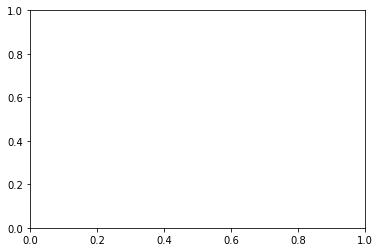

In [41]:
sdf = pd.DataFrame.from_dict(stopping_points)
recalls = []
wss_ps = []
fig, ax = plt.subplots()
for name, group in sdf.groupby(['recall_target','confidence']):
    recalls.append(group['recall'])
    wss_ps.append(group['wss_p'])
    
ax.boxplot(recalls)
plt.show()

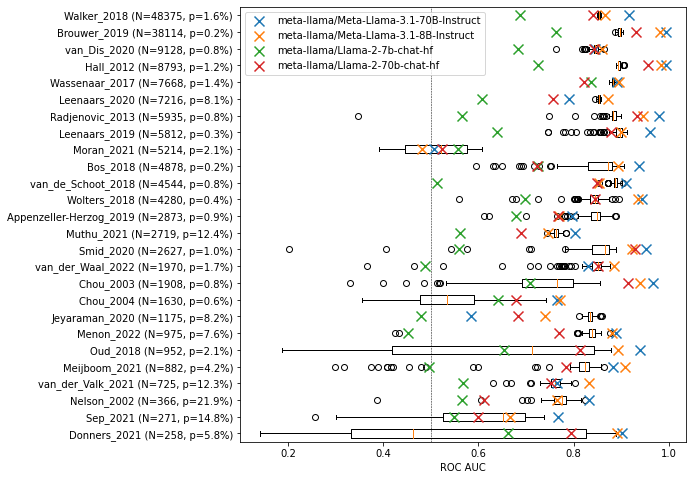

In [42]:
fig, ax = plt.subplots(figsize=(8,8))

ax.boxplot(svm_auc_scores, vert=False)
#llm_auc_scores
ax.set_yticklabels(reviews)
for i, m in enumerate(models):
    scores = [x[i] for x in llm_auc_scores]
    ax.scatter(
        scores, 
        np.arange(len(scores))+1,
        marker='x',
        s=100,
        zorder=50,
        label=m
    )

ax.legend()
ax.axvline(0.5, lw=0.5, ls='--', color='black')
ax.set_xlabel('ROC AUC')
plt.savefig('figures/llm_svm_roc.pdf', bbox_inches='tight')
plt.show()

In [72]:
from buscarpy import retrospective_h0
batch_size=1000
model = 'meta-llama/Llama-2-7b-chat-hf'
review_name = 'Wolters_2018'
filters = [('review', '=', review_name),('model', '=', model)]
llm_df = pq.read_table(f'output_data/llm_preds',filters=filters).to_pandas().dropna()
llm_df = llm_df[pd.notnull(llm_res.index)]
llm_df['pred'] = llm_df['py'] - llm_df['pn']
llm_df = llm_df.sort_values('pred', ascending=False).reset_index()
llm_df['screened_order'] = np.arange(llm_df.shape[0])
for recall_target in [0.8,0.9,0.95,0.99]:
    pdf = pd.DataFrame(
        retrospective_h0(
            llm_df['y'], llm_df.shape[0], 
            batch_size=batch_size, plot=False, recall_target=recall_target,
            confidence_level=0.99
        )
    ).rename(columns={'p': f'p_{recall_target}'})
    llm_df = llm_df.merge(
        pdf, left_on='screened_order', right_on='batch_sizes', how='left',
    ).drop(columns='batch_sizes').ffill()
    break
llm_df = llm_df.set_index('openalex_id')
llm_df

,y,py,pn,review,model,pred,screened_order,p_0.8
openalex_id,,,,,,,,
https://openalex.org/W2042870589,0,0.999987,2.085297e-07,Wolters_2018,meta-llama/Llama-2-7b-chat-hf,0.999987,0,NaN
https://openalex.org/W1980799691,0,0.999981,2.307697e-07,Wolters_2018,meta-llama/Llama-2-7b-chat-hf,0.999980,1,NaN
https://openalex.org/W1976726807,0,0.999979,9.109093e-08,Wolters_2018,meta-llama/Llama-2-7b-chat-hf,0.999978,2,NaN
https://openalex.org/W2049909558,0,0.999976,2.400003e-07,Wolters_2018,meta-llama/Llama-2-7b-chat-hf,0.999976,3,NaN
https://openalex.org/W2079976120,0,0.999975,6.162410e-08,Wolters_2018,meta-llama/Llama-2-7b-chat-hf,0.999975,4,NaN
...,...,...,...,...,...,...,...,...
https://openalex.org/W1702627033,0,0.001001,9.988042e-01,Wolters_2018,meta-llama/Llama-2-7b-chat-hf,-0.997804,4275,0.000396
https://openalex.org/W2022743307,0,0.000721,9.989385e-01,Wolters_2018,meta-llama/Llama-2-7b-chat-hf,-0.998218,4276,0.000396
https://openalex.org/W2366959778,0,0.000495,9.989610e-01,Wolters_2018,meta-llama/Llama-2-7b-chat-hf,-0.998466,4277,0.000396


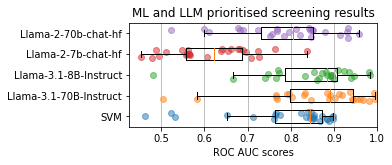

In [10]:
scaler = 1.5
fig, ax = plt.subplots(figsize=(3.7*scaler,1.6*scaler))
meds = [np.median(x) for x in svm_auc_scores]
valid_llm_auc_scores = [[y for y in x if y is not None] for x in np.array(llm_auc_scores).T]
ax.boxplot(
    [meds] + valid_llm_auc_scores,
    vert=False, widths=0.6, showfliers=False,
)
noise = (np.random.random(size=len(meds))-.5)/2
ax.scatter(
    meds, 1+noise,
    alpha=0.5
)

for i, scores in enumerate(valid_llm_auc_scores):
    noise = (np.random.random(size=len(scores))-.5)/2
    ax.scatter(
        scores, 2+i+noise,
        alpha=0.5
    )
    
model_names = [x.split('/')[1].replace('Meta-','') for x in models]
ax.set_yticklabels(['SVM']+model_names)

ax.set_xlabel('ROC AUC scores')
ax.set_title('ML and LLM prioritised screening results')
ax.grid(axis='x')
ax.set_xlim(xmax=1)

fig.tight_layout()
    
plt.savefig('figures/macro_comparison.pdf', bbox_inches='tight')

In [11]:
model = models[1]
review_name = 'Brouwer_2019'
llm_df = pq.read_table(
    f'output_data/llm_preds',
    filters=[
        ('review', '=', review_name),
        ('model', '=', model)
    ]
).to_pandas()
llm_df = proc_llm_df(llm_df)
llm_df

,y,py,pn,review,model,pred,pmass,alt_pred,recall,order,x
openalex_id,,,,,,,,,,,
https://openalex.org/W2535323633,1,0.996989,0.000662,Brouwer_2019,meta-llama/Meta-Llama-3.1-8B-Instruct,0.996327,0.997650,0.993986,0.016129,0,0.000000
https://openalex.org/W2032916808,0,0.995154,0.001351,Brouwer_2019,meta-llama/Meta-Llama-3.1-8B-Instruct,0.993803,0.996505,0.990330,0.016129,1,0.000026
https://openalex.org/W2613037413,0,0.994973,0.001435,Brouwer_2019,meta-llama/Meta-Llama-3.1-8B-Instruct,0.993538,0.996408,0.989969,0.016129,2,0.000052
https://openalex.org/W2896320919,0,0.995438,0.001995,Brouwer_2019,meta-llama/Meta-Llama-3.1-8B-Instruct,0.993443,0.997433,0.990893,0.016129,3,0.000079
https://openalex.org/W2738442045,0,0.994463,0.001740,Brouwer_2019,meta-llama/Meta-Llama-3.1-8B-Instruct,0.992723,0.996203,0.988954,0.016129,4,0.000105
...,...,...,...,...,...,...,...,...,...,...,...
https://openalex.org/W1569802529,0,0.000272,0.997859,Brouwer_2019,meta-llama/Meta-Llama-3.1-8B-Instruct,-0.997587,0.998131,-0.995722,1.000000,38109,0.999869
https://openalex.org/W1577452758,0,0.000332,0.998106,Brouwer_2019,meta-llama/Meta-Llama-3.1-8B-Instruct,-0.997774,0.998437,-0.996215,1.000000,38110,0.999895
https://openalex.org/W1996690535,0,0.000245,0.998051,Brouwer_2019,meta-llama/Meta-Llama-3.1-8B-Instruct,-0.997806,0.998296,-0.996105,1.000000,38111,0.999921


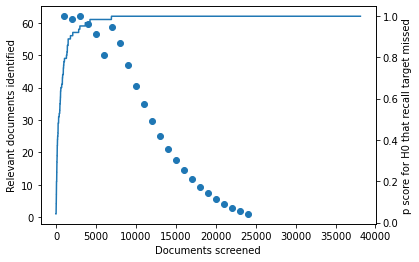

In [12]:
from buscarpy import retrospective_h0

y = llm_df.sort_values('py', ascending=False).reset_index(drop=True).y
h0 = retrospective_h0(y, llm_df.shape[0])

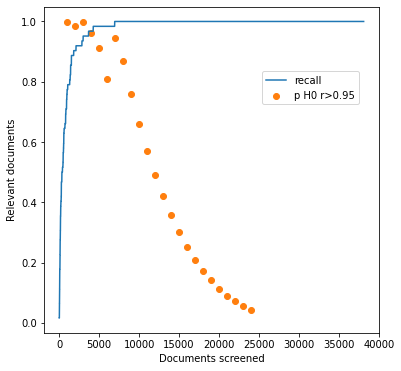

In [13]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(y.cumsum()/y.sum(), label='recall')

ax.set_ylabel('Relevant documents')



ax.scatter(h0['batch_sizes'], h0['p'], c='C1', label='p H0 r>0.95')

ax.legend(loc=(0.65,0.7))

ax.set_xlabel('Documents screened')

plt.savefig('figures/stopping.pdf', bbox_inches='tight')